# Sklearn Workshop 3: Car Price Prediction (Regression)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: ETL

In [2]:
df = pd.read_csv("data/car.csv")

In [3]:
# df.describe()  #no missing values, seems like....
# df.dtypes
# df['selling_price'].value_counts()  #no need to check imbalanced because this is a regression problem
df.head()

#?Note: We don't need the year.....because year can be linearly correlated with price but with no meaning due to inflation anyway
#?      Some missing values in seats?
#?      Wow, so many object.....we need encoding :-(
#?      We don't need name too....because name won't be related to price.....
#?      Oh...we have to fix the mileage and remove kmpl....
#?      We have to remove CC in engine
#?      We have to remove bhp
#?      Based on domain expert, we shall drop torque (ok?)

#selling_price:  our target

#continuous: km_driven, mileage, engine, max_power, torque
#discrete:   seats, fuel, seller_type, transmission, owner, 

#seats can be both continuous or discrete...up to you

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


### 1.1  Fix the columns (extract the meaning from the text)

In [4]:
df['owner'].value_counts()

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

In [5]:
df['owner'] = df['owner'].map({'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4, 'Test Drive Car': 5})

In [6]:
df['owner'].value_counts()

1    5289
2    2105
3     555
4     174
5       5
Name: owner, dtype: int64

In [7]:
df.fuel.value_counts()

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

In [8]:
#let's delete all rows with CNG and LPG
#because CNG and LPG use a different mileage system, i.e., km/kg which is different from kmpl for Diesel and Petrol
condCNG = df.fuel == 'CNG'
condLPG = df.fuel == 'LPG'
condCNG_index = np.where(condCNG | condLPG)  #retrieve the index
df.drop(condCNG_index[0], axis=0, inplace=True)

In [9]:
df.fuel.value_counts()

Diesel    4402
Petrol    3631
Name: fuel, dtype: int64

In [10]:
df.mileage = df.mileage.str.split(" ").str[0]

In [11]:
df.engine = df.engine.str.split(" ").str[0]

In [12]:
df.max_power = df.max_power.str.split(" ").str[0]

In [13]:
df = df.rename(columns={'name': 'brand'})

In [14]:
df.brand = df.brand.str.split(" ").str[0]  #a scientist choice, no right no wrong....

In [15]:
df = df.drop(columns=['torque'])

In [16]:
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.4,1248,74,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498,103.52,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.7,1497,78,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.0,1396,90,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.1,1298,88.2,5.0


In [17]:
df.mileage = df.mileage.astype('float')
df.engine  =  df.engine.astype('float')
df.max_power = df.max_power.astype('float')

In [18]:
df.dtypes

brand             object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner              int64
mileage          float64
engine           float64
max_power        float64
seats            float64
dtype: object

### Step 2: EDA

In [19]:
df.head(1)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.4,1248.0,74.0,5.0


In [24]:
dis_col = ['brand', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']
con_col = ['year', 'km_driven', 'mileage', 'engine', 'max_power']

In [27]:
#plot the categorical columns
for col in dis_col:
    sns.barplot(x = df[col], y = df['selling_price'])  #since our y is continuous, we put x as our categories, and use bar plot
    plt.xticks(rotation=90)
    plt.show()

#? We learn that:  brand, fuel, seller_type, transmission, owner*, seats
#? We have to check the owner, and maybe fix the outliers...........
#? So we deleted the test drive, so now we can use owner as another nice feature, because 1 owner is most expensive....

In [31]:
#we found out there are only five test drive cars...and they are "ridicously expensive"
#also we are not interested in predicting price of test_drive cars
#so let's delete them
cond = df.owner != 5
df = df[cond]

#another way
# cond = df.owner == 5
# index = np.where(cond)
# df = df.drop(index)

In [32]:
df.owner.value_counts()

1    5238
2    2073
3     547
4     170
Name: owner, dtype: int64

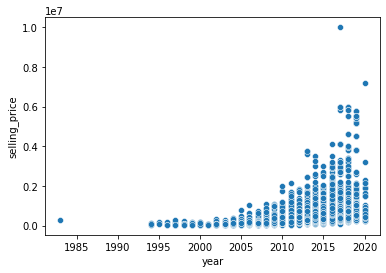

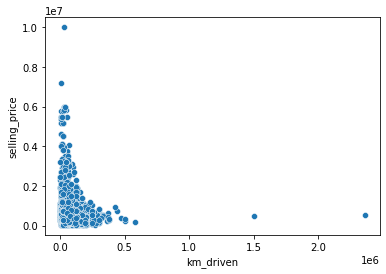

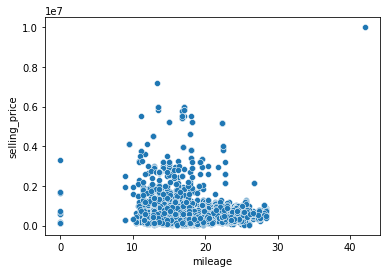

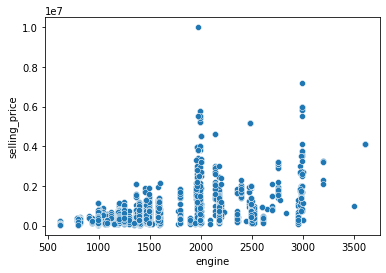

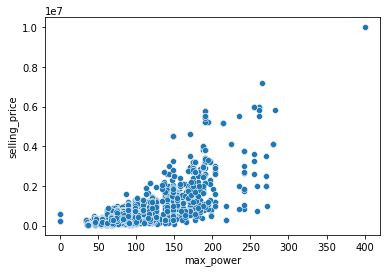

In [33]:
for col in con_col:
    sns.scatterplot(x=df[col], y=df['selling_price'])  #use scatter plot because both are continuous
    plt.show()
    
#? We learn that (very strong):  battery_power, px_height, px_width, ram
#?               (some trend) :  int_memory, 
#? Hmm...maybe let the corr() confirms out for us.....

In [ ]:
# plt.figure(figsize=(20, 10))
# sns.heatmap(df.corr(), annot=True)

#? Things with around >0.4-0.5 correlation with price_range:  ram
#? Things with around >0.1     correlation with price_range:  battery_power, px_height, px_width

#? So in conclusion, we will use ram, battery_power, px_height, px_width
#? Note: you can use all features, but it can increase your model complexity.....unnecessarily

### Step 3: Splitting

In [ ]:
X = df[ ['ram', 'battery_power', 'px_height', 'px_width'] ]
y = df['price_range']

assert X.ndim == 2
assert y.ndim == 1

X.shape, y.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=999)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Step 4: Preprocessing

##### 4.1 Filling missing values

In [ ]:
#double check that no missing values....
# X_train.isna().sum() 
# X_test.isna().sum() 
# y_train.isna().sum() 
# y_test.isna().sum()

##### 4.2 Encoding

In [ ]:
#all our values do not need to encode, because they are all numeric :-)

##### 4.3 Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train) #we scale all features, because all our features are continuous
X_test  = sc.transform(X_test)

#we did not transform y_test or y_train

#after standardize, the mean should be zero; the std should be 1
for feature in range(X_train.shape[1]):
    assert np.isclose(X_train[:, feature].mean(), 0)  #cannot == 0 because is near 0 not 0
    assert np.isclose(X_train[:, feature].std(),  1)

### Step 5: Modeling

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#models
lr, nb, sv, rf, gb = LogisticRegression(), GaussianNB(), SVC(), RandomForestClassifier(), GradientBoostingClassifier()

models = [lr, nb, sv, rf, gb]
names  = ["lr", "nb", "sv", "rf", "gb"]

for idx, model in enumerate(models):
    score = cross_val_score(model, X_train, y_train, n_jobs=-1) #no need cv and scoring because their default is ok in our case
    print(f"{names[idx]} - Mean: {score.mean()}; Std: {score.std()}")

In [ ]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(random_state=999)  #<----this is the model I choose, after cross validation

param_grid = dict()
param_grid['solver'] = ['newton-cg', 'lbfgs', 'liblinear']  #this is listed in the sklearn website
#add more parameters here
#param_grid[parameter] = list of parameters to search

#refit means it will pick the best model, and fit again, so it means grid is already the best model after this line
grid = GridSearchCV(model, param_grid, refit=True, return_train_score=True)
#scoring = f1, recall, precision, accuracy

#fit the grid, which will basically do cross validation across all combinatiosn, here we only have 3 comb
grid.fit(X_train, y_train)  #remember to use only training set here....

#print the best parameters and accuracy
print(grid.best_params_)
print(grid.best_score_)
# print(grid.cv_results_)   #hide this for aesthetic

#this score is cross-validation score, basically the accuracy/precision/etc on the validation set

#?Note:  our train score is around 0.95, 0.95, 0.82;  the val score is 0.95, 0.96, 0.82
#?       so no overfitting....because they are close
#?Note:  if we have overfitting, we need to check many things, e.g., 
#?       - choose simpler model
#?       - help the model choose better features
#?       - collect more high quality data, and more data....
#?       - or maybe your data has no pattern!! :-) the model is just learning pattern of noises......

### Step 6: Testing

In [ ]:
pred_y = grid.predict(X_test)

#if your website needs probability, you can use 
#proba or log_proba are same, log_proba just make the value more scaled....
#?  Note:  some algorithm has no predict_proba() so please check
    #pred_y_prob = grid.predict_proba(X_test)
#or
    #pred_y_logprob = grid.predict_log_proba(X_test)

In [ ]:
pred_y

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, pred_y))
#? Note:  we can use all four metrics to understand
#? Accuracy:  0.95 - we can use it because our data is balanced
#? Precision: 0.95 - look at this metric if you want to prioritize lowering FP
#? Recall:    0.95 - look at this metirc if you want to prioritize lowering FN
#? F1-score:  0.95 - look at this metric if you want to prioritize lowering both FP and FN

#?macro-avg average all classes
#?weighted-avg average all classes * their fraction of sample sizes

#?if your data is balanced, both avg will be the same (anyway)

In [ ]:
cm  = confusion_matrix(y_test, pred_y)
cmp = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3])

cmp.plot()

#? Note:  0 is often confused as 1
#?        1 is confused as 2
#?        2 is confused as 3
#?  This makes sense because close price range may be easily confused.......i guess (i don't know)

In [ ]:
#let's check which sample like to get wrong, especially "0 is often confused as 1"
conda = pred_y == 0
condb = y_test == 1

X_test[conda & condb]  
#so i will leave at that....but if you are the domain expert, you can check here....
 

### Step 7: Feature Importance

In [ ]:
grid.best_estimator_.coef_ #(n_classes, n_features)
#n_classes means 0, 1, 2, 3
#if we have only two classes, it will be (1, n_features), because it can 0 or 1

In [ ]:
feature_importance = pd.DataFrame(['ram', 'battery_power', 'px_height', 'px_width'], 
                                  columns=['features'])
feature_importance["0"] = grid.best_estimator_.coef_[0]
feature_importance["1"] = grid.best_estimator_.coef_[1]
feature_importance["2"] = grid.best_estimator_.coef_[2]
feature_importance["3"] = grid.best_estimator_.coef_[3]

for _class in ['0', '1', '2', '3']:  
    feature_importance = feature_importance.sort_values(by = [_class], ascending=True)
    feature_importance.plot.barh(x='features', y=_class)
    plt.show()
    
#? What we learn:
#? Class 0:  Ram is most important;  Ram negatively impact the price_range of 0
#? Class 1:  Ram is most important;  Ram negatively impact the price_range of 1
#? Class 2:  Ram is most important;  Ram positively impact the price_range of 2
#? Class 3:  Ram is most important;  Ram positively impact the price_range of 3

#? Overall, all importances point out that ram > battery_power > px_width > px_height

### Step 8: Saving the models

In [ ]:
#please help me save the model here
import pickle

# save the model
filename = 'mobile_price.pkl' # pkl does not matter, you can do .everything
pickle.dump(grid, open(filename,'wb'))

# Load the model
loaded_grid=pickle.load(open(filename,'rb'))

# try predict X_test
loaded_grid.predict(X_test)

# if you have new data, then you fit again....but using loaded_grid
# which is a process of training more.....once you have more data....

# or another way is
# put all the dataset together, and train like it is new
    #this is possible ONLY if your dataset is not that big......


### For real world prediction

In [ ]:
#for actual use? to predict some future data.....
some_data = np.array([ [1, 2, 3, 4], [2, 3, 4, 5] ])

#standardize
some_data = sc.transform(some_data)

#predict
pred = grid.predict(some_data)

pred #both samples have price_range of 3 (predicted, NOT actual, because we don't have actual)

In [ ]:
stock = np.array([ [1, 1.01, 0.99, 0.80, 0.5, 0.9, 1.1, 1.2]])

#window size = 3
#predict the next 2 days

#X_1 = 1, 1.01, 0.99
#y_1 = 0.80, 0.5

#X_2 = 1.01, 0.99, 0.80
#y_2 = 0.5, 0.9

#X_3 = 0.99, 0.80, 0.5
#y_3 = 0.9, 1.1

#so on.....
#this will be your training set!!

# for in range(, , window_size):
#     X = 
#     y = 